In [1]:
import pandas as pd
from mapping import util
from mapping import mappings
import mapping.plot as mplot
import matplotlib.pyplot as plt
import os
%pylab inline

/home/matthew/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/matthew/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Populating the interactive namespace from numpy and matplotlib


In [2]:
!ls

continous_returns.ipynb  data  xiv_comparison.ipynb


## Read price and settlement date data

In [3]:
def read_prices(files):

    settles = []
    for file in files:
        ast = os.path.split(file)[-1].split("-")[-1].split(".")[0]
        ast = ast[3:] + ast[:2] + ast[2]
        df = pd.read_csv(file, index_col=0, parse_dates=True)
        s = df.loc[:, "Settle"]
        s.index = pd.MultiIndex.from_product([s.index, [ast]])
        settles.append(s)
    
    prices = pd.concat(settles, axis=0).sort_index()
    return prices

In [4]:
files = ["CME-FVH2014.csv", "CME-FVM2015.csv", "CME-FVZ2014.csv", "CME-FVH2015.csv",
         "CME-FVU2014.csv", "CME-FVZ2015.csv", "CME-FVM2014.csv", "CME-FVU2015.csv"]

files = [os.path.join('data', f) for f in files]

prices = read_prices(files)
prices.head()

2012-12-31  2014FVH    123.16406
2013-01-02  2014FVH    123.10938
2013-01-03  2014FVH    122.88281
2013-01-04  2014FVH    122.80469
2013-01-07  2014FVH    122.82031
Name: Settle, dtype: float64

In [5]:
prices.tail()

2015-12-24  2015FVZ    119.007812
2015-12-28  2015FVZ    119.015625
2015-12-29  2015FVZ    118.695312
2015-12-30  2015FVZ    118.726562
2015-12-31  2015FVZ    118.843750
Name: Settle, dtype: float64

In [6]:
# needed because of https://github.com/pandas-dev/pandas/issues/21200
rets = prices.groupby(level=-1).apply(lambda x: x.pct_change())
rets.head()

2012-12-31  2014FVH         NaN
2013-01-02  2014FVH   -0.000444
2013-01-03  2014FVH   -0.001840
2013-01-04  2014FVH   -0.000636
2013-01-07  2014FVH    0.000127
Name: Settle, dtype: float64

In [7]:
contract_dates = pd.read_csv("data/fv_contract_dates.csv", index_col="contract", parse_dates=[1, 2])
contract_dates

,first_notice,last_trade
contract,,
2014FVH,2014-02-28,2014-03-31
2014FVM,2014-05-30,2014-06-30
2014FVU,2014-08-29,2014-09-30
2014FVZ,2014-11-28,2014-12-31
2015FVH,2015-02-27,2015-03-31
2015FVM,2015-05-29,2015-06-30
2015FVU,2015-08-31,2015-09-30
2015FVZ,2015-11-30,2015-12-31
2016FVH,2016-02-29,2016-03-31


In [8]:
contract_dates = contract_dates.min(axis=1)
contract_dates

contract
2014FVH   2014-02-28
2014FVM   2014-05-30
2014FVU   2014-08-29
2014FVZ   2014-11-28
2015FVH   2015-02-27
2015FVM   2015-05-29
2015FVU   2015-08-31
2015FVZ   2015-11-30
2016FVH   2016-02-29
dtype: datetime64[ns]

### Select dates consistent with contract expiry data given

In [9]:
ts = rets.index.levels[0]
ts = ts[ts >= pd.Timestamp("2014-01-01")]
ts = ts[ts <= pd.Timestamp("2015-11-25")]

## Construct roll rules, roll over two days leading up a fixed date

In [10]:
cols = pd.MultiIndex.from_product([["FV1"], ['front', 'back']])
idx = [-2, -1, 0]
transition = pd.DataFrame([[1.0, 0.0], [0.5, 0.5], [0.0, 1.0]], index=idx, columns=cols)
transition

FV1     
   front back
-2   1.0  0.0
-1   0.5  0.5
 0   0.0  1.0

## Create roll weights

In [11]:
weights_pre_expiry = mappings.roller(ts, contract_dates, mappings.static_transition,
                                     transition=transition)
weights_pre_expiry.head()

,generic,FV1
date,contract,
2014-01-02,2014FVH,1.0
2014-01-03,2014FVH,1.0
2014-01-06,2014FVH,1.0
2014-01-07,2014FVH,1.0
2014-01-08,2014FVH,1.0


## Calculate Continuous Returns with first weighting

In [12]:
rets1 = util.reindex(rets, weights_pre_expiry.index, limit=1)

In [13]:
continous_rets = util.calc_rets(rets1, weights_pre_expiry)
continous_rets.head()

,FV1
date,
2014-01-02,-0.030511
2014-01-03,-0.000458
2014-01-06,0.001309
2014-01-07,0.000915
2014-01-08,-0.003788


## Create roll rule for rolling all in one day after a give fixed date

In [14]:
cols = pd.MultiIndex.from_product([["FV1"], ['front', 'back']])
idx = [0, 1]
transition_month = pd.DataFrame([[1.0, 0.0], [0.0, 1.0]], index=idx, columns=cols)

transition_month

FV1     
  front back
0   1.0  0.0
1   0.0  1.0

## Create roll rules for rolling at start of the last trade date month

In [15]:
bom = contract_dates - pd.offsets.BMonthBegin(1)
weights_start_month = mappings.roller(ts, bom, mappings.static_transition,
                                      transition=transition_month)

weights_start_month.head()

,generic,FV1
date,contract,
2014-01-02,2014FVH,1.0
2014-01-03,2014FVH,1.0
2014-01-06,2014FVH,1.0
2014-01-07,2014FVH,1.0
2014-01-08,2014FVH,1.0


## Compare the rolling in of contracts for different rules

In [16]:
pd.concat([weights_pre_expiry, weights_start_month], axis=1, keys=["Rule1", "Rule2"]).loc["2014-02"].fillna(value=0)

Rule1 Rule2
generic               FV1   FV1
date       contract            
2014-02-03 2014FVH    1.0   1.0
2014-02-04 2014FVH    1.0   0.0
           2014FVM    0.0   1.0
2014-02-05 2014FVH    1.0   0.0
           2014FVM    0.0   1.0
2014-02-06 2014FVH    1.0   0.0
           2014FVM    0.0   1.0
2014-02-07 2014FVH    1.0   0.0
           2014FVM    0.0   1.0
2014-02-10 2014FVH    1.0   0.0
           2014FVM    0.0   1.0
2014-02-11 2014FVH    1.0   0.0
           2014FVM    0.0   1.0
2014-02-12 2014FVH    1.0   0.0
           2014FVM    0.0   1.0
2014-02-13 2014FVH    1.0   0.0
           2014FVM    0.0   1.0
2014-02-14 2014FVH    1.0   0.0
           2014FVM    0.0   1.0
2014-02-18 2014FVH    1.0   0.0
           2014FVM    0.0   1.0
2014-02-19 2014FVH    1.0   0.0
           2014FVM    0.0   1.0
2014-02-20 2014FVH    1.0   0.0
           2014FVM    0.0   1.0
2014-02-21 2014FVH    1.0   0.0
           2014FVM    0.0   1.0
2014-02-24 2014FVH    1.0   0.0
           2014FVM    0.0   1.0
2014-02-25 2014FVH    1.0   0.0
           2014FVM    0.0   1.0
2014-02-26 2014FVH    1.0   0.0
           2014FVM    0.0   1.0
2014-02-27 2014FVH    0.5   0.0
           2014FVM    0.5   1.0
2014-02-28 2014FVM    1.0   1.0

## Calculate continuous returns with second weighting

In [17]:
rets2 = util.reindex(rets, weights_start_month.index, limit=1)
continous_rets_month_start = util.calc_rets(rets2, weights_start_month)

In [18]:
continous_rets_month_start.head()

,FV1
date,
2014-01-02,-0.030511
2014-01-03,-0.000458
2014-01-06,0.001309
2014-01-07,0.000915
2014-01-08,-0.003788


In [19]:
contract_rets = pd.pivot_table(rets.reset_index(), values="Settle", index="level_0", columns="level_1")

In [20]:
contract_rets.head()

level_1,2014FVH,2014FVM,2014FVU,2014FVZ,2015FVH,2015FVM,2015FVU,2015FVZ
level_0,,,,,,,,
2013-01-02,-0.000444,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,-0.001840,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-04,-0.000636,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-07,0.000127,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-08,0.001209,NaN,NaN,NaN,NaN,NaN,NaN,NaN


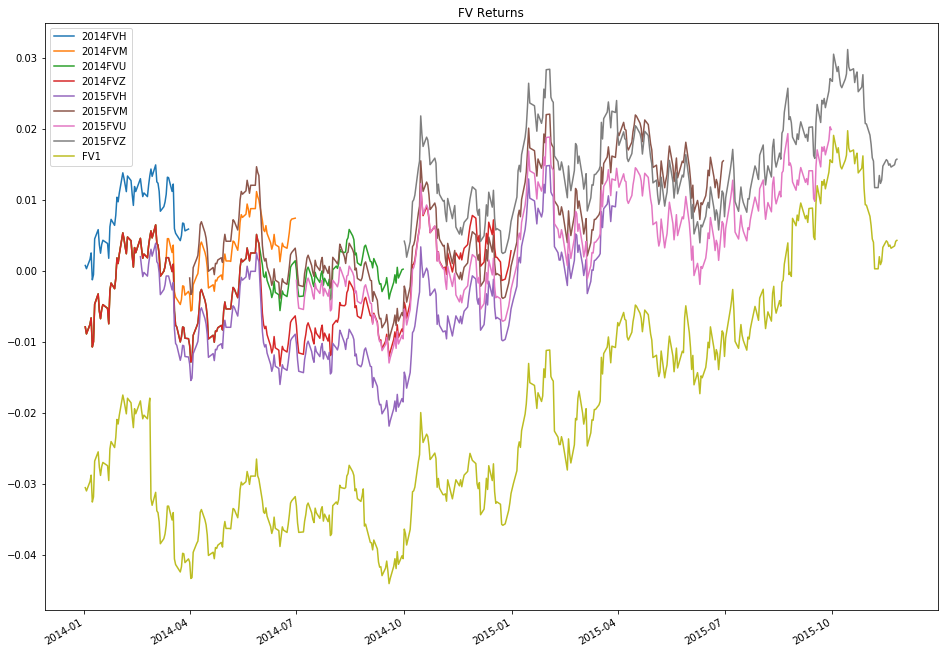

In [21]:
both_rets = pd.concat([contract_rets, continous_rets], axis=1)
both_rets.loc[ts, :].cumsum().plot(figsize=(16, 12), title="FV Returns")

In [22]:
both_rets = pd.concat([contract_rets, continous_rets], axis=1)
both_rets.loc[ts, :].cumsum().head()

,2014FVH,2014FVM,2014FVU,2014FVZ,2015FVH,2015FVM,2015FVU,2015FVZ,FV1
2014-01-02,0.000786,-0.007858,-0.007858,-0.007858,NaN,NaN,NaN,NaN,-0.030511
2014-01-03,0.000328,-0.008848,-0.008848,-0.008848,NaN,NaN,NaN,NaN,-0.030969
2014-01-06,0.001637,-0.007526,-0.007526,-0.007526,NaN,NaN,NaN,NaN,-0.029659
2014-01-07,0.002552,-0.006603,-0.006603,-0.006603,NaN,NaN,NaN,NaN,-0.028744
2014-01-08,-0.001236,-0.010689,-0.010689,-0.010689,NaN,NaN,NaN,NaN,-0.032532


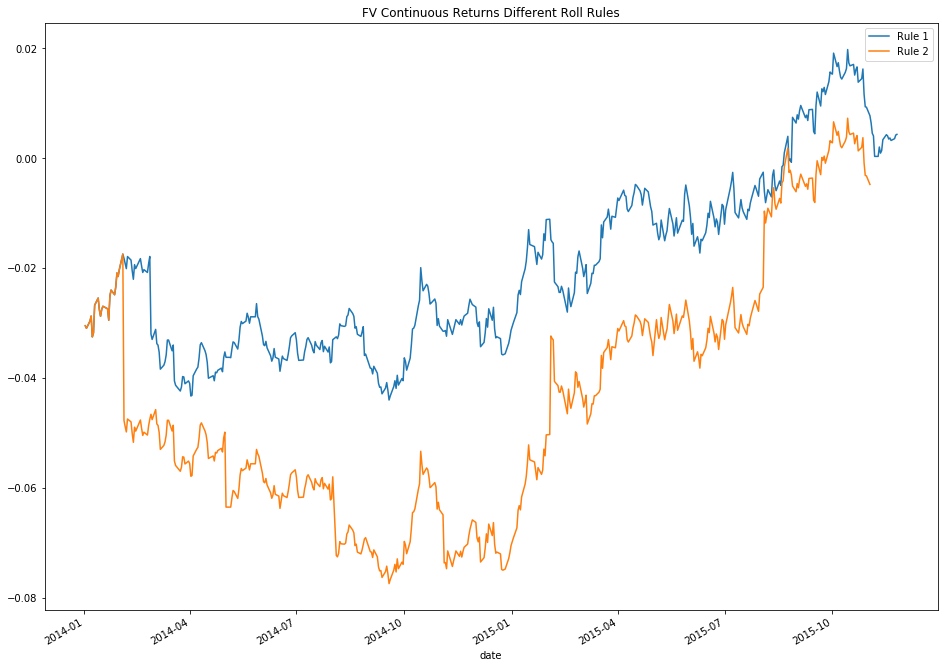

In [23]:
crets = pd.concat([continous_rets, continous_rets_month_start], axis=1)
crets.columns = ["Rule 1", "Rule 2"]
crets.cumsum().plot(figsize=(16, 12), title="FV Continuous Returns Different Roll Rules")

## Show underlyings

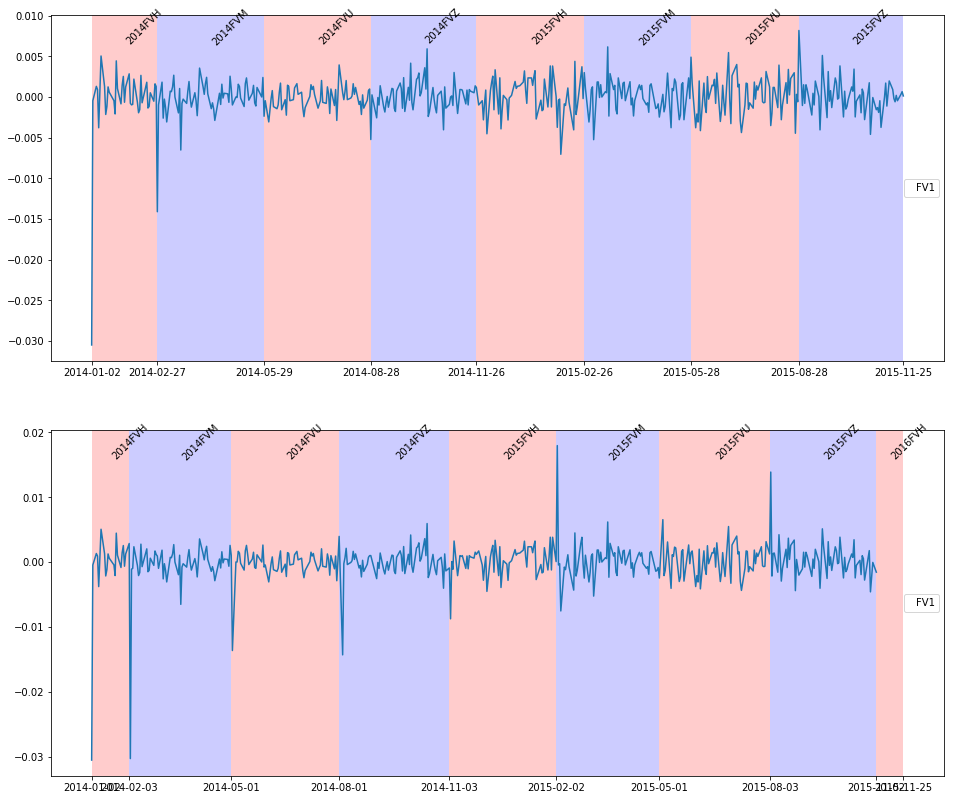

In [24]:
_, axes = plt.subplots(2, 1, figsize=(16, 14))

intrvls1 = mplot.intervals(weights_pre_expiry)
intrvls2 = mplot.intervals(weights_start_month)
mplot.plot_composition(continous_rets, intrvls1, axes=[axes[0]])
mplot.plot_composition(continous_rets_month_start, intrvls2, axes=[axes[1]])

## Calculate trades for a given date with first weighting

In [25]:
dt = pd.Timestamp("2015-11-25")
notional = pd.Series(100000, index=["FV1"])
wts_t = weights_pre_expiry.loc[dt]
prices_t = prices.loc[dt]
current_contracts = 0
generic_multiplier = pd.Series([1000])

print("Weights")
print(wts_t)

print("\n\nPrices")
print(prices_t)

Weights
generic   FV1
contract     
2015FVZ   1.0


Prices
2015FVZ    119.179688
Name: Settle, dtype: float64


### Utility method for looking up tradeable multipliers based on weights and generic instrument multipliers

In [26]:
multipliers = util.get_multiplier(wts_t, generic_multiplier)
multipliers

2015FVZ    1000
dtype: int64

### Instrument trades

In [27]:
trades = util.calc_trades(current_contracts, notional, wts_t, prices_t, multipliers=multipliers)
trades

contract
2015FVZ    1
dtype: int64

### Look at residual arising for contract rounding

In [28]:
traded_notional = util.to_notional(trades + current_contracts, prices_t, multipliers=multipliers)
residual = notional - mappings.to_generics(traded_notional, wts_t)
residual

FV1   -19179.6875
dtype: float64